In [1]:
from rasterio.warp import calculate_default_transform, reproject
import rasterio
import numpy
import geopandas as gpd
import os
import matplotlib.pyplot as plt

os.environ['PROJ_LIB'] = r'E:\\开源\\mymy\\1\\.venv\\Lib\\site-packages\\rasterio\\proj_data'

In [2]:
# 定义重投影函数
def img_reproj(data_rio, ref_data=None, crs_dst=None, output_path=None):
    """
    重投影栅格数据函数。
 
    参数:
    data_rio: rasterio类对象，表示待重投影的栅格数据。
    ref_data: 参考数据，可以是栅格数据、rasterio对象或矢量数据（GeoDataFrame），提供重投影坐标系。
    crs_dst: epsg格式的坐标系，用于指定重投影的目标坐标系（如果ref_data提供，则此参数可选）。
    output_path: 保存重投影后数据的路径。
 
    返回:
    data_reproj_rio: 重投影后的rasterio栅格对象。
    """
 
    # 检查ref_data和crs_dst参数，确保至少有一个被设置
    if ref_data is None and crs_dst is None:
        raise ValueError("必须设置ref_data或crs_dst参数之一")
 
    # 提取参考数据的坐标系
    if isinstance(ref_data, str):  # ref_data是文件路径
        if ref_data.lower().endswith(('.tif', '.tiff')):  # 参考数据为栅格数据
            with rasterio.open(ref_data) as ref_rio:
                crs_dst = ref_rio.crs
        else:  # 参考数据为矢量数据
            gdf = gpd.read_file(ref_data)
            crs_dst = gdf.crs.to_string()
    elif isinstance(ref_data, rasterio.io.DatasetReader):  # rasterio对象
        crs_dst = ref_data.crs
    elif isinstance(ref_data, gpd.GeoDataFrame):  # GeoDataFrame对象
        crs_dst = ref_data.crs.to_string()
 
    # 获取原始栅格数据的坐标系
    crs_src = data_rio.crs
 
    # 计算重投影所需的变换参数
    transform, width, height = calculate_default_transform(
        crs_src, crs_dst, data_rio.width, data_rio.height, *data_rio.bounds
    )
 
    # 创建一个新的rasterio对象，用于存储重投影后的数据
    kwargs = data_rio.meta.copy()
    kwargs.update({
        'crs': crs_dst,
        'transform': transform,
        'width': width,
        'height': height
    })
 
    # 重投影数据
    with rasterio.Env():
        with rasterio.open(data_rio.name) as src:
            if output_path:
                # 如果指定了输出路径，则直接保存到磁盘
                with rasterio.open(output_path, 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=crs_dst,
                            resampling=rasterio.warp.Resampling.bilinear
                        )
                    return None  # 不返回rasterio对象，因为已经保存到磁盘
            else:
                # 如果没有指定输出路径，则保存到内存并返回
                data_reproj_rio = rasterio.MemoryFile()
                with data_reproj_rio.open(**kwargs) as memfile:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(memfile, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=crs_dst,
                            resampling=rasterio.warp.Resampling.bilinear
                        )
                return data_reproj_rio

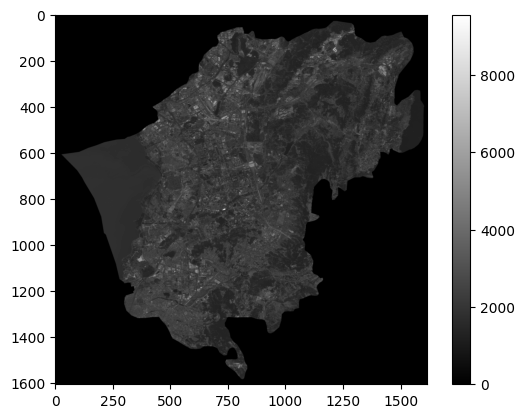

原始数据名称: cg_utm.tif
我指定的转换坐标：EPSG:4326
转换后数据名称: reproj_crs_dst.tif
重投影前的坐标系: EPSG:32647
重投影后的坐标系: EPSG:4326
重投影后的数据形状: (6, 1605, 1615)
重投影后的数据范围: BoundingBox(left=102.69987471207241, bottom=24.694208661889597, right=103.00327398086422, top=24.99572929743811)


In [8]:
# 情况(1)：
# 通过crs_dst指定重投影坐标系：
# 1. 读取原始栅格数据
data_rio = rasterio.open('E:\\开源\\HW5\\cg_utm.tif')
# 2. 设置目标坐标系
crs_dst = 'EPSG:4326'
# 3. 设置输出路径
output_path = 'E:\\开源\\HW5\\reproj_crs_dst.tif'

# 4. 调用重投影函数，并保存到指定路径
img_reproj(data_rio, crs_dst=crs_dst, output_path=output_path)

# 5. 重新打开保存后的重投影数据，以显示和检查
with rasterio.open(output_path) as reproj_data:
    # 读取所有波段的数据
    reproj_data_arr = reproj_data.read()
    # 使用第一个波段的数据进行灰度图显示
    plt.imshow(reproj_data_arr[0], cmap='gray')  # 显示第一个波段
    plt.colorbar()  # 显示色标
    plt.show()
    # 输出原始数据名称
    print(f"原始数据名称: {os.path.basename(data_rio.name)}")
    # 输出指定的转换EPSG坐标
    print(f"我指定的转换坐标：{crs_dst}")
    # 输出转换后数据名称
    print(f"转换后数据名称: {os.path.basename(output_path)}")
    # 输出重投影前的坐标系
    print(f"重投影前的坐标系: {data_rio.crs}")
    # 输出重投影后的数据的坐标系等信息
    print(f"重投影后的坐标系: {reproj_data.crs}")
    print(f"重投影后的数据形状: {reproj_data_arr.shape}")  # 应该与原始数据的波段数一致
    print(f"重投影后的数据范围: {reproj_data.bounds}")

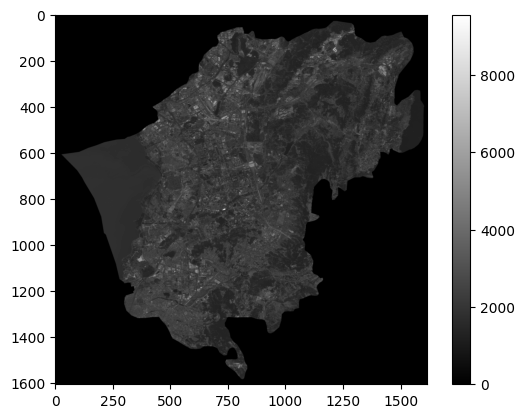

原始数据名称: cg_utm.tif
参考数据名称: cg_WGS84.tif
转换后数据名称: reproj_ref_data_tif.tif
重投影前的坐标系: EPSG:32647
重投影后的坐标系: EPSG:4326
重投影后的数据形状: (6, 1605, 1615)
重投影后的数据范围: BoundingBox(left=102.69987471207241, bottom=24.694208661889597, right=103.00327398086422, top=24.99572929743811)


In [7]:
# 情况(2)：
# ref_data为参考数据，接受栅格或矢量数据实现重投影：
# 1. 读取原始栅格数据
data_rio = rasterio.open('E:\\开源\\HW5\\cg_utm.tif')
 
# 2. 设置参考数据路径（可以是栅格或矢量数据路径）
ref_data_path = 'E:\\开源\\HW5\\cg_WGS84.tif'  # 示例为矢量数据路径，可以改为栅格数据路径'E:\\开源\\HW5\\cg_WGS84.tif'
 
# 3. 设置输出路径
output_path='E:\\开源\\HW5\\reproj_ref_data_tif.tif'

# 3. 调用重投影函数（不指定crs_dst，因为ref_data已提供坐标系）
img_reproj(data_rio, ref_data=ref_data_path, output_path=output_path)
 
# 4. 重新打开保存后的重投影数据，以显示和检查
with rasterio.open('E:\\开源\\HW5\\reproj_ref_data_shp.tif') as reproj_data:
    # 读取所有波段的数据
    reproj_data_arr = reproj_data.read()
    # 使用第一个波段的数据进行灰度图显示
    plt.imshow(reproj_data_arr[0], cmap='gray')  # 显示第一个波段
    plt.colorbar()  # 显示色标
    plt.show()

    # 输出原始数据名称
    print(f"原始数据名称: {os.path.basename(data_rio.name)}")
    # 输出参考数据名称
    print(f"参考数据名称: {os.path.basename(ref_data_path)}")
    # 输出转换后数据名称
    print(f"转换后数据名称: {os.path.basename(output_path)}")
    # 输出重投影前的坐标系
    print(f"重投影前的坐标系: {data_rio.crs}")
    # 输出重投影后的数据的坐标系等信息
    print(f"重投影后的坐标系: {reproj_data.crs}")
    print(f"重投影后的数据形状: {reproj_data_arr.shape}")  # 应该与原始数据的波段数一致
    print(f"重投影后的数据范围: {reproj_data.bounds}")